In [1]:
import tensorflow as tf
import numpy as np

/Users/linchenxiao/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# Training samples path, change to your local path
training_samples_file_path = tf.keras.utils.get_file("trainingSamples.csv", "file:/Users/linchenxiao/Python_Code/Spark/SparrowRecsys/sampledata/trainingSamples.csv")
# Test samples path, change to your local path
test_samples_file_path = tf.keras.utils.get_file("testSamples.csv", "file:/Users/linchenxiao/Python_Code/Spark/SparrowRecsys/sampledata/testSamples.csv")


# load sample as tf dataset
def get_dataset(file_path):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=12,
        label_name='label',
        na_value="0",
        num_epochs=1,
        ignore_errors=True)
    return dataset


# split as test dataset and training dataset
train_dataset = get_dataset(training_samples_file_path)
test_dataset = get_dataset(test_samples_file_path)

# genre features vocabulary
genre_vocab = ['Film-Noir', 'Action', 'Adventure', 'Horror', 'Romance', 'War', 'Comedy', 'Western', 'Documentary',
               'Sci-Fi', 'Drama', 'Thriller',
               'Crime', 'Fantasy', 'Animation', 'IMAX', 'Mystery', 'Children', 'Musical']

GENRE_FEATURES = {
    'userGenre1': genre_vocab,
    'userGenre2': genre_vocab,
    'userGenre3': genre_vocab,
    'userGenre4': genre_vocab,
    'userGenre5': genre_vocab,
    'movieGenre1': genre_vocab,
    'movieGenre2': genre_vocab,
    'movieGenre3': genre_vocab
}

# all categorical features
categorical_columns = []
for feature, vocab in GENRE_FEATURES.items():
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
    emb_col = tf.feature_column.embedding_column(cat_col, 10)
    categorical_columns.append(emb_col)
# movie id embedding feature
movie_col = tf.feature_column.categorical_column_with_identity(key='movieId', num_buckets=1001)
movie_emb_col = tf.feature_column.embedding_column(movie_col, 10)
categorical_columns.append(movie_emb_col)

# user id embedding feature
user_col = tf.feature_column.categorical_column_with_identity(key='userId', num_buckets=30001)
user_emb_col = tf.feature_column.embedding_column(user_col, 10)
categorical_columns.append(user_emb_col)

# all numerical features
numerical_columns = [tf.feature_column.numeric_column('releaseYear'),
                     tf.feature_column.numeric_column('movieRatingCount'),
                     tf.feature_column.numeric_column('movieAvgRating'),
                     tf.feature_column.numeric_column('movieRatingStddev'),
                     tf.feature_column.numeric_column('userRatingCount'),
                     tf.feature_column.numeric_column('userAvgRating'),
                     tf.feature_column.numeric_column('userRatingStddev')]

# cross feature between current movie and user historical movie
# 用户刚刚的好评电影，和现在准备推荐的电影
rated_movie = tf.feature_column.categorical_column_with_identity(key='userRatedMovie1', num_buckets=1001)
crossed_feature = tf.feature_column.indicator_column(tf.feature_column.crossed_column([movie_col, rated_movie], 10000))

# define input for keras model
inputs = {
    'movieAvgRating': tf.keras.layers.Input(name='movieAvgRating', shape=(), dtype='float32'),
    'movieRatingStddev': tf.keras.layers.Input(name='movieRatingStddev', shape=(), dtype='float32'),
    'movieRatingCount': tf.keras.layers.Input(name='movieRatingCount', shape=(), dtype='int32'),
    'userAvgRating': tf.keras.layers.Input(name='userAvgRating', shape=(), dtype='float32'),
    'userRatingStddev': tf.keras.layers.Input(name='userRatingStddev', shape=(), dtype='float32'),
    'userRatingCount': tf.keras.layers.Input(name='userRatingCount', shape=(), dtype='int32'),
    'releaseYear': tf.keras.layers.Input(name='releaseYear', shape=(), dtype='int32'),

    'movieId': tf.keras.layers.Input(name='movieId', shape=(), dtype='int32'),
    'userId': tf.keras.layers.Input(name='userId', shape=(), dtype='int32'),
    'userRatedMovie1': tf.keras.layers.Input(name='userRatedMovie1', shape=(), dtype='int32'),

    'userGenre1': tf.keras.layers.Input(name='userGenre1', shape=(), dtype='string'),
    'userGenre2': tf.keras.layers.Input(name='userGenre2', shape=(), dtype='string'),
    'userGenre3': tf.keras.layers.Input(name='userGenre3', shape=(), dtype='string'),
    'userGenre4': tf.keras.layers.Input(name='userGenre4', shape=(), dtype='string'),
    'userGenre5': tf.keras.layers.Input(name='userGenre5', shape=(), dtype='string'),
    'movieGenre1': tf.keras.layers.Input(name='movieGenre1', shape=(), dtype='string'),
    'movieGenre2': tf.keras.layers.Input(name='movieGenre2', shape=(), dtype='string'),
    'movieGenre3': tf.keras.layers.Input(name='movieGenre3', shape=(), dtype='string'),
}

# wide and deep model architecture
# deep part for all input features
deep = tf.keras.layers.DenseFeatures(numerical_columns + categorical_columns)(inputs)
deep = tf.keras.layers.Dense(128, activation='relu')(deep)
deep = tf.keras.layers.Dense(128, activation='relu')(deep)
# wide part for cross feature
wide = tf.keras.layers.DenseFeatures(crossed_feature)(inputs)
both = tf.keras.layers.concatenate([deep, wide])
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(both)
model = tf.keras.Model(inputs, output_layer)

# compile the model, set loss function, optimizer and evaluation metrics
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')])

# train the model
model.fit(train_dataset, epochs=5)

# evaluate the model
test_loss, test_accuracy, test_roc_auc, test_pr_auc = model.evaluate(test_dataset)
print('\n\nTest Loss {}, Test Accuracy {}, Test ROC AUC {}, Test PR AUC {}'.format(test_loss, test_accuracy,
                                                                                   test_roc_auc, test_pr_auc))

# print some predict results
predictions = model.predict(test_dataset)
for prediction, goodRating in zip(predictions[:12], list(test_dataset)[0][1][:12]):
    print("Predicted good rating: {:.2%}".format(prediction[0]),
          " | Actual rating label: ",
          ("Good Rating" if bool(goodRating) else "Bad Rating"))

Epoch 1/5


/Users/linchenxiao/.pyenv/versions/3.8.5/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['rating', 'timestamp', 'userRatedMovie2', 'userRatedMovie3', 'userRatedMovie4', 'userRatedMovie5', 'userAvgReleaseYear', 'userReleaseYearStddev'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


7403/7403 [==============================] - 24s 3ms/step - loss: 1.1256 - accuracy: 0.5730 - auc: 0.5865 - auc_1: 0.6367
Epoch 2/5
7403/7403 [==============================] - 20s 3ms/step - loss: 0.6144 - accuracy: 0.6669 - auc: 0.7190 - auc_1: 0.7446
Epoch 3/5
7403/7403 [==============================] - 20s 3ms/step - loss: 0.5602 - accuracy: 0.7134 - auc: 0.7792 - auc_1: 0.8010
Epoch 4/5
7403/7403 [==============================] - 20s 3ms/step - loss: 0.5153 - accuracy: 0.7469 - auc: 0.8188 - auc_1: 0.8395
Epoch 5/5
1870/1870 [==============================] - 6s 2ms/step - loss: 0.6330 - accuracy: 0.6695 - auc: 0.7342 - auc_1: 0.7585


Test Loss 0.633030891418457, Test Accuracy 0.6695187091827393, Test ROC AUC 0.7342421412467957, Test PR AUC 0.7585367560386658
Predicted good rating: 16.09%  | Actual rating label:  Good Rating
Predicted good rating: 90.25%  | Actual rating label:  Bad Rating
Predicted good rating: 61.94%  | Actual rating label:  Good Rating
Predicted good rating:

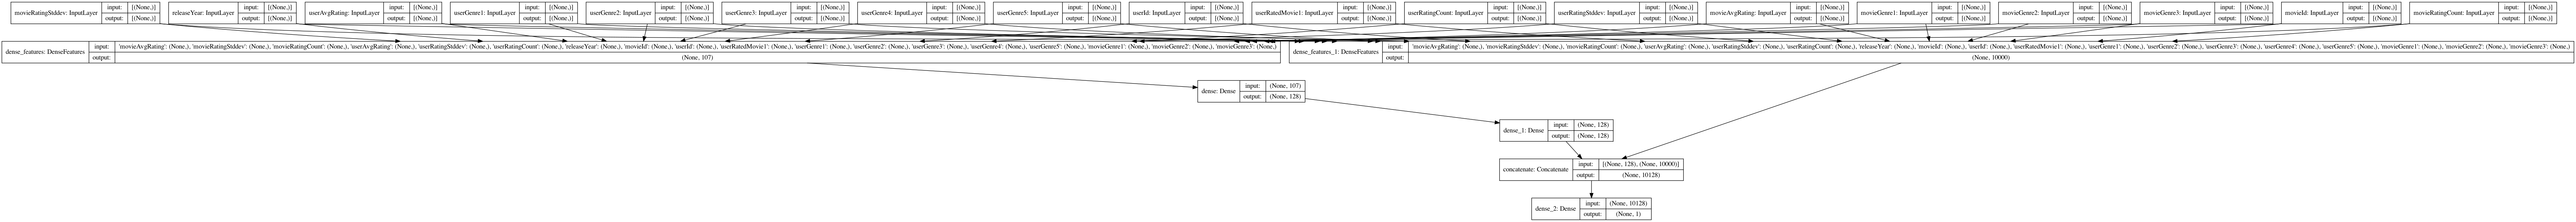

In [4]:
tf.keras.utils.plot_model(model, to_file="WideDeep.png", show_shapes=True)